# Performing Quantum Measurements in QuTiP

* EuroSciPy 2019
* Simon Cross

### Outline

* Why this weird quantum mechanics anyway?
* Simulating a simple classical system.
* What is a classical bit?
* What is a qubit?
* Measuring a qubit.
* Simulating a simple quantum experiment in QuTiP.

### Meta goals

* Use QuTiP to try things out.
* Try understand what we're doing!

# Imports: Our tools

In [1]:
%matplotlib inline

from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import qutip
from qutip import Qobj, Bloch, basis, ket, tensor

Define LaTeX commands:
* $\newcommand{\ket}[1]{\left|{#1}\right\rangle}$ $\ket{0}$
* $\newcommand{\bra}[1]{\left\langle{#1}\right|}$ $\bra{1}$
* $\newcommand{\abs}[1]{\lvert{#1}\rvert}$ $\abs{x}$

# The Stern-Gerlach Experiment

Why this weird quantum mechanics anyway?

### Apparatus

<center><img src="images/stern-gerlach-apparatus-cm.png"></center>

Great drawing from: http://hyperphysics.phy-astr.gsu.edu/hbase/spin.html

See also:
    
* https://plato.stanford.edu/entries/physics-experiment/app5.html.
* https://en.wikipedia.org/wiki/Stern%E2%80%93Gerlach_experiment#History
    
for more on the history of the Stern-Gerlach experiment.

Why did they decide to do this?

It had become generally accepted that atoms could behave as tiny magnets.

In the classical model of the atom, electrons orbit the nucleus. A charge orbiting in a circle generates a magnetic field -- so atoms should act like tiny magnets and be deflected by an inhomogenous magnetic field.

Stern had the idea that this deflection would help better measure and understand the magnetic moment of the atoms & Gerlach brought the experimental expertise.

\begin{align}
F_z & = \mu_z \frac{\partial B}{\partial z} \\
    & = ( \hat{\mu} \cdot \hat{z} ) |\mu| \frac{\partial B}{\partial z} \\
    & \propto \hat{\mu} \cdot \hat{z}
\end{align}

Here $\hat \mu$ is the magnetic moment (strength and direction of the atom's magnetic field) and $\hat z$ is the direction in which the magnetic field varies (and which the measurement is made in).

The assumptions that the magnitude of the the atoms magnetic moment $\abs{\mu}$ and the inhomogeneity of the magnetic field are constant allow us to make the last statement that $F_z$ is proportional to the dot product of $\hat \mu$ and $\hat z$.

Now for fun, let's display the $\hat \mu$ and $\hat z$ vectors using QuTiP's `Bloch` class. For now consider this class just a handy way to plot vectors -- we will be learning more about what it is later on.

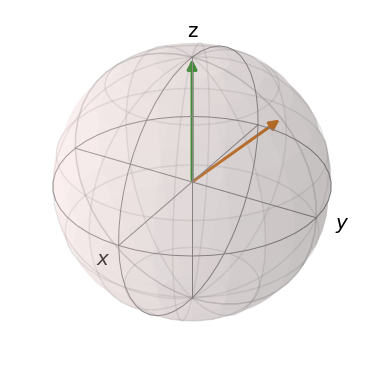

In [2]:
z = np.array([0, 0, 1])
mu = np.array([0, 1, 1]) / np.sqrt(2)

bloch = Bloch()
bloch.zlabel=("z", "")
bloch.add_vectors([z, mu])
bloch.show()

# Let's simulate the Stern-Gerlach in Python!

Simulating a simple classical system.

In [3]:
# Simulation of expected results in the classical case

Direction = namedtuple("Direction", ["theta", "phi"])


def random_direction():
    """ Generate a random direction. """
    # See http://mathworld.wolfram.com/SpherePointPicking.html
    r = 0
    while r == 0:
        x, y, z = np.random.normal(0, 1, 3)
        r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(y, x)
    theta = np.arccos(z / r)
    return Direction(theta=theta, phi=phi)

In [4]:
def classical_state(d):
    """ Prepare a spin state given a direction. """
    x = np.sin(d.theta) * np.cos(d.phi) 
    y = np.sin(d.theta) * np.sin(d.phi)
    z = np.cos(d.theta)
    return np.array([x, y, z])

In [5]:
classical_up = np.array([0, 0, 1])

def classical_spin(c):
    """ Measure the z-component of the spin. """
    return classical_up.dot(c)

In [6]:
def classical_stern_gerlach(n):
    """ Simulate the Stern-Gerlach experiment """
    directions = [random_direction() for _ in range(n)]
    atoms = [classical_state(d) for d in directions]
    spins = [classical_spin(c) for c in atoms]
    return atoms, spins

In [7]:
def plot_classical_results(atoms, spins):
    fig = plt.figure(figsize=(18.0, 8.0))
    fig.suptitle("Stern-Gerlach Experiment: Classical Outcome", fontsize="xx-large")

    ax1 = plt.subplot(1, 2, 1, projection='3d')
    ax2 = plt.subplot(1, 2, 2)

    b = Bloch(fig=fig, axes=ax1)
    b.vector_width = 1
    b.vector_color = ["#ff{:x}0ff".format(i, i) for i in range(10)]
    b.zlabel = ["$z$", ""]
    b.add_vectors(atoms)
    b.render(fig=fig, axes=ax1)

    ax2.hist(spins)
    ax2.set_xlabel("Z-component of spin")
    ax2.set_ylabel("# of atoms")

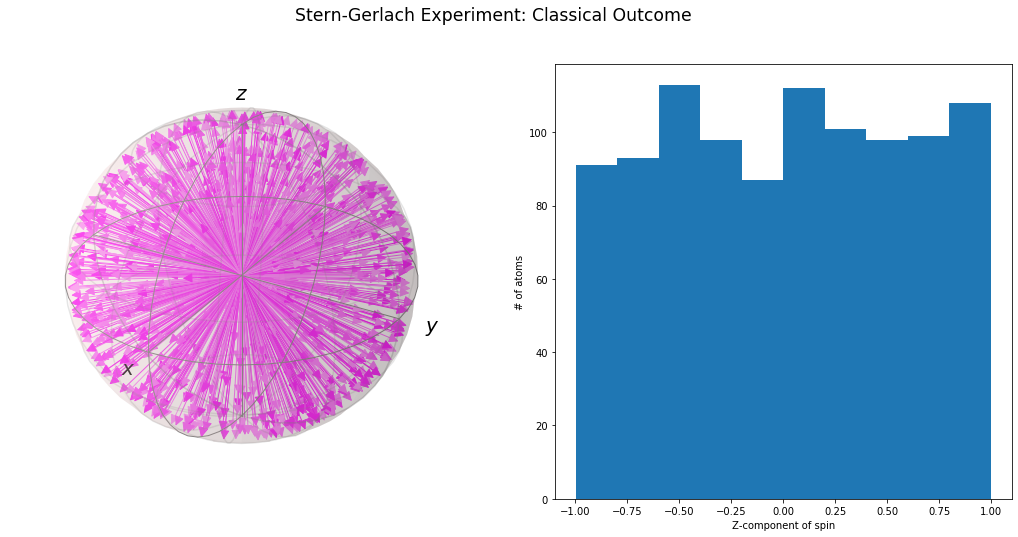

In [8]:
atoms, spins = classical_stern_gerlach(1000)
plot_classical_results(atoms, spins)

# The actual results

<img src="images/stern-gerlach-fig13-results.jpg">

In [9]:
def plot_real_vs_actual(spins):
    fig = plt.figure(figsize=(18.0, 8.0))
    fig.suptitle("Stern-Gerlach Experiment: Real vs Actual", fontsize="xx-large")

    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    ax1.hist([np.random.choice([1, -1]) for _ in spins])
    ax1.set_xlabel("Z-component of spin")
    ax1.set_ylabel("# of atoms")
    
    ax2.hist(spins)
    ax2.set_xlabel("Z-component of spin")
    ax2.set_ylabel("# of atoms")

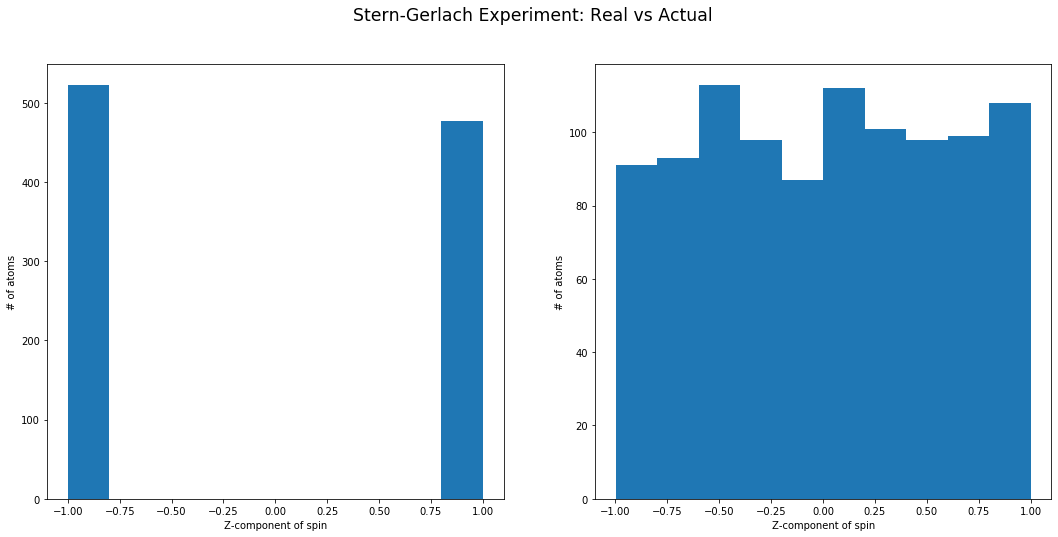

In [10]:
plot_real_vs_actual(spins)

# Uh-oh.

This really is a system with two outcomes.

# If we align all the spins perpendicular to the z-axis:

* Our classical simulator would show no force on any of the atoms.
* The actual result would be the same as for the random spin case.

# If we align all the spins with the z-axis:

* Our classical simulator would show always 1.
* The actual result would match that of the classical simulator.

## It's like tossing a biased coin.

# Classical bit

Something we're familiar with.

### Classical bit

A *classical bit* (bit) is classical system with *two states* and *two outcomes*.

* States: `0` and `1`
* Outcomes: `0` and `1`

### Classical bit

A *classical bit* (bit) is classical system with *two states* and *two outcomes*.

* We can label these two states `0` and `1`.
* Measuring state `0` produces an outcome which we will also label `0`.
* Measuring state `1` produces an outcome which we will also label `1`.
* These are the only two states.
* Measuring the same state always produces the same outcome.

The state is like a Python object. Measurement is an operation that acts on the state and returns an outcome.

Bit is a portmanteau of *binary digit*.

Examples:

* A coin can lie on a surface in two different ways. We measure it by looking at it. We call the outcomes `heads` and `tails`.
* A digital signal can have one of two different voltages. We measure it by measuring the voltage. We call the outcomes `high` and `low` (or `1` and `0`).

With two bits there are four outcomes. With three bits there are eight outcomes. With `n` bits there are `2^n` outcomes.

We need `n` bits to represent `n` bits.

In [11]:
class ClassicalBit:
    def __init__(self, outcome):
        self.outcome = outcome
            
b0 = heads = ClassicalBit(outcome=0)
b1 = tails = ClassicalBit(outcome=1)

def measure_cbit(cbit):
    return cbit.outcome

print("State:\n", b0)
print("Outcome:", measure_cbit(b0))

State:
Outcome: 0


# Quantum bit

Putting the puzzle pieces together.

### Quantum bit

A *quantum bit* (qubit) is quantum system with two *basis states* and *two outcomes*.

* Basis states: `|0>` and `|1>`
* Outcomes: `0` and `1`

*Basis* means "we will construct more states from these later".

### Quantum Bit

A *quantum bit* (qubit) is quantum system with two two *basis states* and two outcomes.

* We can label these two basis states `|0>` and `|1>`.
* Measuring state `|0>` produces an outcome which we will label `0`.
* Measuring state `|1>` produces an outcome which we will label `1`.
* There are other states called *superpositions* which we label `a|0> + b|1>`.
  * `a` and `b` are complex numbers.
* Measuring a state produces outcome `0` with probability `|a|^2` and outcome `1` with probability `|b|^2`. 

Qubit is a portmanteau of *quantum bit* (it's portmanatees all the way down).

Examples:

* A coin can lie on a surface in two different ways. We measure it by looking at it. We call the outcomes `heads` and `tails`.
* A digital signal can have one of two different volates. We measure it by measuring the voltage. We call the outcomes `high` and `low` (or `1` and `0`).

With two qubits there are four outcomes. With three qubits there are eight outcomes. With `n` qubits there are `2^n` outcomes.

We `2^n` (minus 1) complex numbers to represent `n` qubits.

In [12]:
b0 = ket("0")  # |0>
b1 = ket("1")  # |1>

print("State:\n", b1)

State:
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]


In [13]:
def measure_qbit(qbit):
    if qbit == ket("0"):
        return 0
    if qbit == ket("1"):
        return 1
    raise NotImplementedError("No clue yet. :)")
    
print("Outcome:", measure_qbit(b1))

Outcome: 1


# What about the "in between" states?

The tricky part. :)

# We want probabilistic outcomes

Let's try something simple for the other states:

* $a \ket{0} + b \ket{1}$
* Probability of outcome $0$: $a$
* Probability of outcome $1$: $b$

We need:

* $a + b = 1$
* $1 >= a >= 0$
* $1 >= b >= 0$

In [14]:
def plot_real_a_b():
    fig = plt.figure(figsize=(18.0, 8.0))
    fig.suptitle("Probabilities: Real $a$ and $b$", fontsize="xx-large")

    ax = plt.subplot(1, 1, 1)

    ax.plot([0, 1], [1, 0])
    ax.set_xlabel("$a$")
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylabel("$b$")
    ax.set_ylim(-0.5, 1.5)

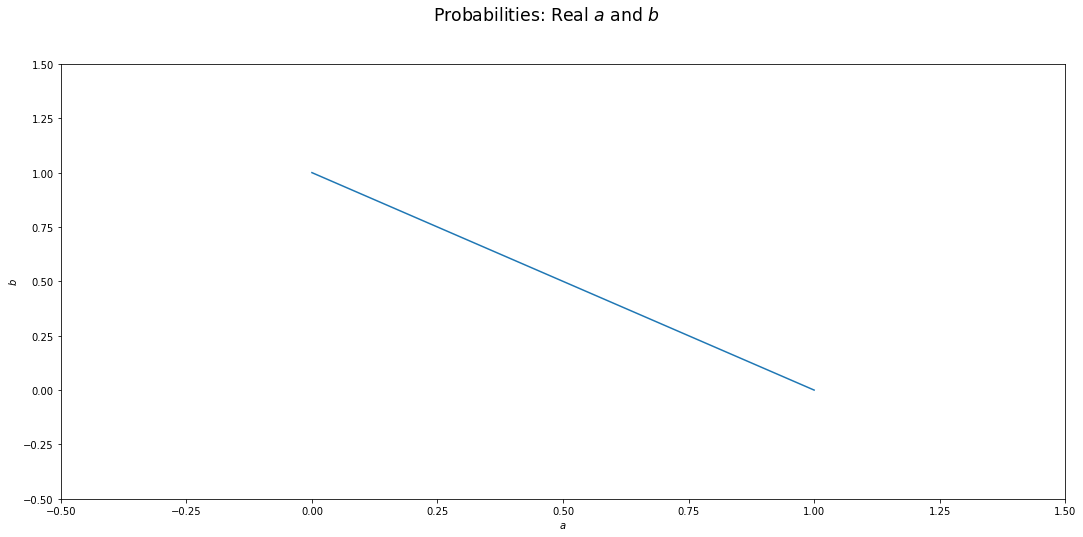

In [15]:
plot_real_a_b()

# Hmm. That didn't work.

Let's try something slightly more complicated:

* $a \ket{0} + b \ket{1}$
* $a, b \in \mathbb{C}$
* Probability of outcome $0$: $\abs{a}^2$
* Probability of outcome $1$: $\abs{b}^2$

<center><img src="images/complex-movie-loop-f7.gif"></center>

<center><img src="images/complex-movie-loop.gif"></center>

# Complex numbers summary

* $a = x + y \cdot j$
    * Length: $\sqrt{x^2 + y^2}$
    * Angle ($\theta$): $arctan(y / x)$
* Python:
    * Length: `np.abs(a)`
    * Angle ($\theta$): `np.angle(a)`

# Complex numbers in terms of length and angle

* $a = m \cdot cos(t) + m \cdot sin(t) \cdot j$
* $a = m \cdot e ^ {t \cdot j}$
    * Length: $m$
    * Angle: $t$

# Global phase

* 4 real parameters, minus one from $\abs{a}^2 + \abs{b}^2 = 1$
* Still one too many.
* Let's remove one!
* Declare that only the relative angles of $a$ and $b$ are important.

This means we can rotate the two vectors on the complex plane as long as we don't change the angle between them. Note that this doesn't change the magnitude of a or b (and thus doesn't change the probabilities).

# The qubit states

* General state: `a|0> + b|1>`
  * where $a$ and $b$ are complex numbers
  * $\abs{a}^2 + \abs{b}^2 = 1$
  * global phase is irrelevant:
    * $a = a \cdot e^{t \cdot j}, b = b \cdot e^{t \cdot j}$
* Outcome:
  * `0` with probability $\abs{a}^2$
  * `1` with probability $\abs{b}^2$

### Bloch sphere

This leaves only two real numbers:

* The relative magnitudes of `|a|` and `|b|`.
* The relative angle between `a` and `b`.

Both of these form circles -- and the together the two circles form a sphere!

Named after Felix Block (also the first director of CERN!)

Wow, this looks a lot like a direction in space! Making progress!

# How to sound smart at parties

* SU(2) is isomorphic to SO(3)

* `SU(2)` - the state space of qubits, aka the bloch sphere.
* `SO(3)` - the space of directions in 3D, aka a sphere.
* The state space of possible qubits is a sphere.

# QuTiP has nice tools for visualising Bloch spheres

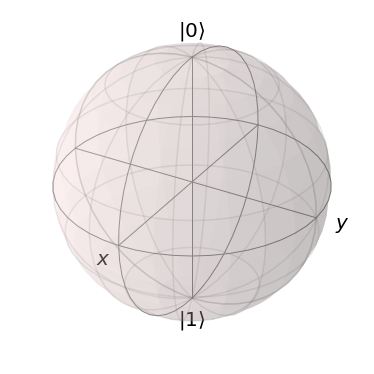

In [16]:
b = Bloch()
b.show()

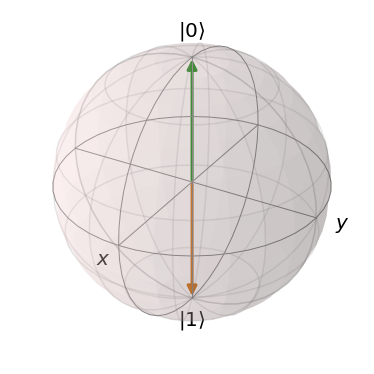

In [17]:
b = Bloch()
up = ket("0")
down = ket("1")
b.add_states([up, down])
b.show()

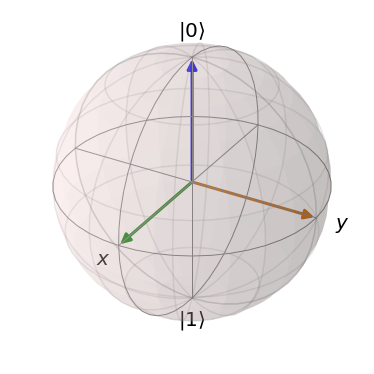

In [18]:
x = (up + down).unit()
y = (up + (0 + 1j) * down).unit()
z = up
b = Bloch()
b.add_states([x, y, z])
b.show()

In [19]:
def plot_bloch(fig, ax, title, states, color_template):
    """ Plot some states on the bloch sphere. """
    b = Bloch(fig=fig, axes=ax)
    ax.set_title(title, y=-0.01)
    b.vector_width = 1
    b.vector_color = [color_template.format(i * 10) for i in range(len(states))]
    b.add_states(states)
    b.render(fig=fig, axes=ax)

In [20]:
def plot_multi_blochs(plots):
    """ Plot multiple sets of states on bloch spheres. """
    fig = plt.figure(figsize=(18.0, 8.0))
    fig.suptitle("Bloch Sphere", fontsize="xx-large")
    n = len(plots)
    axes = [plt.subplot(1, n, i + 1, projection='3d') for i in range(n)]
    for i, (title, states, color_template) in enumerate(plots):
        plot_bloch(fig, axes[i], title, states, color_template)

In [21]:
up = ket("0")
down = ket("1")

# magnitude_circle = [Qobj([[a], [np.sqrt(1 - a**2)]]) for a in np.linspace(0, 1, 20)]
magnitude_circle = [
    (a * up + np.sqrt(1 - a**2) * down)
    for a in np.linspace(0, 1, 20)
]
# angular_circle = [Qobj([[np.sqrt(0.5)], [np.sqrt(0.5) * np.e ** (1j * theta)]]) for theta in np.linspace(0, np.pi, 20)]
angular_circle = [
    (np.sqrt(0.5) * up + np.sqrt(0.5) * down * np.e ** (1j * theta))
    for theta in np.linspace(0, np.pi, 20)
]

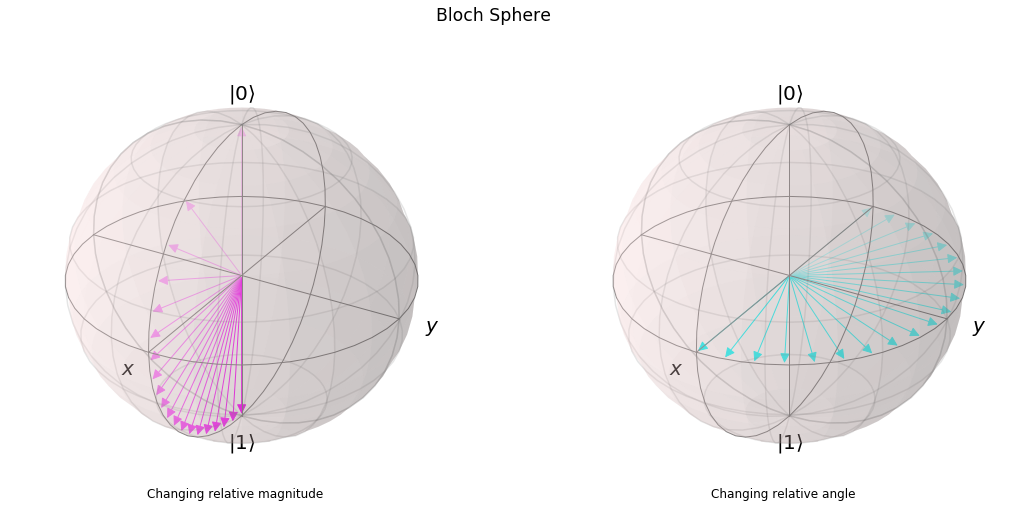

In [22]:
plot_multi_blochs([
    ["Changing relative magnitude", magnitude_circle, "#ff{:02x}ff"],
    ["Changing relative angle", angular_circle, "#{:02x}ffff"],
])

# Measuring a general state

In [23]:
def measure_qbit(qbit):
    a = qbit.full()[0][0]  # a
    b = qbit.full()[1][0]  # b
    if np.random.random() <= np.abs(a) ** 2:
        return 0
    else:
        return 1

In [24]:
# |a|**2 + |b|**2 == 1

a = (1 + 0j) / np.sqrt(2)
b = (0 + 1j) / np.sqrt(2)
qbit = a * ket("0") + b * ket("1")
    
print("State:\n", qbit)
print("Outcome:", measure_qbit(qbit))

State:
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.70710678+0.j        ]
 [0.        +0.70710678j]]
Outcome: 0


In [25]:
qbit = (1 * ket("0")) + (1j * ket("1"))
qbit = qbit.unit()

print("State:\n", qbit)
print("Outcome:", measure_qbit(qbit))

State:
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.70710678+0.j        ]
 [0.        +0.70710678j]]
Outcome: 1


### Other measures

* Was there really anything special about $\ket{0}$ and $\ket{1}$?
* No! :D
  * Except they pointed in opposite directions.
* Can we make other measurements?
  * Yes!

In [26]:
def component(qbit, direction):
    component_op = direction.dag()
    a = component_op * qbit
    return a[0][0]

def measure_qbit(qbit, direction):
    a = component(qbit, direction)
    if np.random.random() <= np.abs(a) ** 2:
        return 0
    else:
        return 1

In [27]:
up, down = ket("0"), ket("1")
x, y, z = (up + down).unit(), (up + (0 + 1j) * down).unit(), up

print("State:\n", x)
print("Outcomes:", [measure_qbit(x, direction=up) for _ in range(10)])

State:
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.70710678]
 [0.70710678]]
Outcomes: [1, 1, 0, 0, 0, 1, 1, 1, 0, 0]


# Let's simulate the Stern-Gerlach with QuTiP!

Simulating a simple ~~classical~~ quantum system.

In [28]:
def quantum_state(d):
    """ Prepare a spin state given a direction. """
    return np.cos(d.theta / 2) * up + np.exp(1j * d.phi) * np.sin(d.theta / 2) * down

In [29]:
up = ket('0')

def quantum_spin(q):
    """ Measurement the z-component of the spin. """
    a_up = (up.dag() * q).tr()
    prob_up = np.abs(a_up) ** 2
    return 1 if np.random.uniform(0, 1) <= prob_up else -1

In [30]:
def quantum_stern_gerlach(n):
    """ Simulate the Stern-Gerlach experiment """
    directions = [random_direction() for _ in range(n)]
    atoms = [quantum_state(d) for d in directions]
    spins = [quantum_spin(q) for q in atoms]
    return atoms, spins

In [31]:
def plot_quantum_results(atoms, spins):
    fig = plt.figure(figsize=(18.0, 8.0))
    fig.suptitle("Stern-Gerlach Experiment: Quantum Outcome", fontsize="xx-large")

    ax1 = plt.subplot(1, 2, 1, projection='3d')
    ax2 = plt.subplot(1, 2, 2)

    b = Bloch(fig=fig, axes=ax1)
    b.vector_width = 1
    b.vector_color = ["#{:x}0{:x}0ff".format(i, i) for i in range(10)]
    b.add_states(atoms)
    b.render(fig=fig, axes=ax1)

    ax2.hist(spins)
    ax2.set_xlabel("Z-component of spin")
    ax2.set_ylabel("# of atoms")

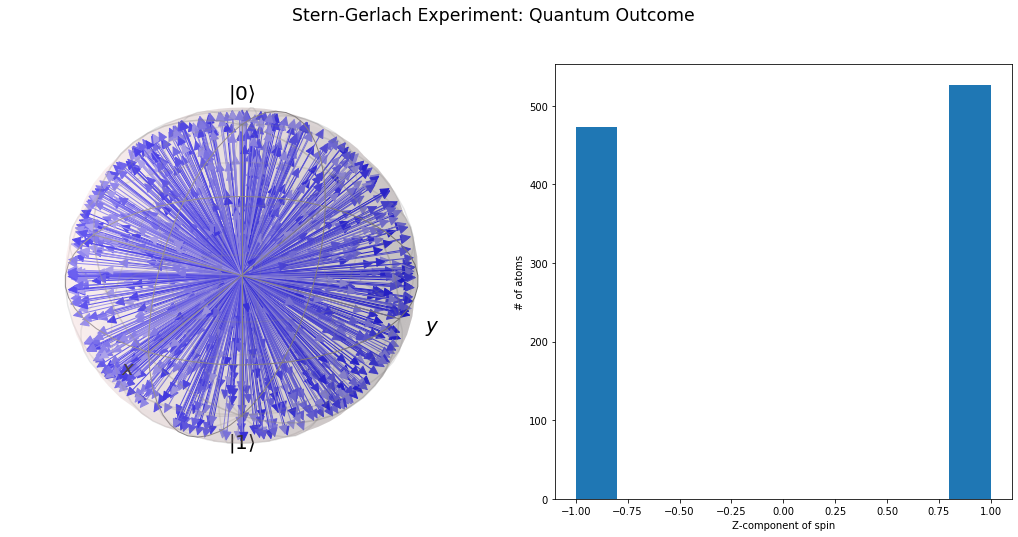

In [32]:
atoms, spins = quantum_stern_gerlach(1000)
plot_quantum_results(atoms, spins)

# Further reading

1. QuTiP documentation [ https://qutip.org/ ]

2. Quantum Computing for the Determined by Michael Nielsen
   [ https://michaelnielsen.org/blog/quantum-computing-for-the-determined/ ]

3. Quantum Computing StackExchange
   [ https://quantumcomputing.stackexchange.com/ ]

4. History of the Stern-Gerlach experiment
   [ https://plato.stanford.edu/entries/physics-experiment/app5.html ]

5. Picking a random point on a sphere
   [ http://mathworld.wolfram.com/SpherePointPicking.html ]

# The End